# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
from keras.layers import Conv3D, Conv3DTranspose, MaxPooling3D, UpSampling3D, ZeroPadding3D, Cropping3D, Input
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


# Reading Data

In [ ]:
# variablesIndex = [5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
# variablesName = ["T", "H", "H2", "O", "O2", "OH", "H2O", "HO2", "H2O2", "CO", "CO2", "CH2O",
#                  "HO2CHO", "O2CHO", "CH3O2H", "CH3O2", "CH4", "CH3", "C2H5", "C2H4", "C2H3",
#                  "CH3CHO", "C2H5OH", "O2C2H4OH"]

variablesIndex = [5, 8, 9, 10]
variablesName = ["T", "H", "H2", "O"]

In [ ]:
# read clean_data for each variable: 560x560 clean_data points read in rows of 10
clean_data = {}
for j in range(len(variablesIndex)):
    clean_data[variablesName[j]] = pd.read_csv(
        '/content/gdrive/My Drive/plane-xy-0.50.2.200E-03.csv',
        skiprows=lambda row: row < (31360 * (variablesIndex[j] - 1) + 37),
        nrows=31360,
        header=None,
        engine='python',
        dtype='float32'
    )

    # (24, 560, 560, 1) -> 4 (24, 280, 280, 1) = 4 of corners of all 24

# Scale and Shape Data

In [ ]:
# scale data
mins, maxs = {}, {}
for key in clean_data.keys():
    mins[key] = clean_data[key].to_numpy().min()
    maxs[key] = clean_data[key].to_numpy().max()
    clean_data[key] = (clean_data[key] - np.full_like(clean_data[key], mins[key])) / (np.full_like(clean_data[key], maxs[key]) - np.full_like(clean_data[key], mins[key]))

# reshape clean_data for each variable into image-like format, 560x560
for key in clean_data.keys():
    clean_data[key] = np.array(clean_data[key]).reshape((560, 560))

# begin adding noise to clean data
noisy_data = dict(clean_data)
for j in range(len(variablesIndex)):
    noisy_data[variablesName[j]] = noisy_data[variablesName[j]] + 0.05 * np.random.normal(loc=0.0, scale=1.0, size=noisy_data[variablesName[j]].shape)

# build training set
num_samples = 3
train_df_noisy, train_df_clean, test_df_noisy, test_df_clean = [], [], [] ,[]
for j in range(int(len(variablesIndex)/2)):
    train_df_noisy.append(noisy_data[variablesName[j]].reshape((560, 560, 1)))
    train_df_clean.append(clean_data[variablesName[j]].reshape((560, 560, 1)))
for j in range(int(len(variablesIndex)/2), int(len(variablesIndex))):
    test_df_noisy.append(noisy_data[variablesName[j]].reshape((560, 560, 1)))
    test_df_clean.append(clean_data[variablesName[j]].reshape((560, 560, 1)))
train_df_noisy, train_df_clean = np.full(shape=(num_samples, len(variablesIndex), 560, 560, 1), fill_value=train_df_noisy[0]), np.full(shape=(num_samples, len(variablesIndex), 560, 560, 1), fill_value=train_df_clean[0])
test_df_noisy, test_df_clean = np.full(shape=(num_samples, len(variablesIndex), 560, 560, 1), fill_value=test_df_noisy[0]), np.full(shape=(num_samples, len(variablesIndex), 560, 560, 1), fill_value=test_df_clean[0])

#Build Autoencoder

In [ ]:
# build autoencoder
input_images = Input(shape=(len(variablesIndex), 560, 560, 1))

encoder = Conv3D(20, 3, padding='same', activation='relu')(input_images)
encoder = MaxPooling3D(pool_size=2, padding='same')(encoder)
encoder = Conv3D(10, 3, padding='same', activation='relu')(encoder)

decoder = Conv3DTranspose(10, 3, padding='same', activation='relu')(encoder)
decoder = UpSampling3D(size=2)(decoder)
decoder = Conv3DTranspose(20, 3, padding='same', activation='relu')(decoder)
decoder = Conv3D(1, 1, padding='same', activation='sigmoid')(decoder)

autoencoder = Model(input_images, decoder)
autoencoder.compile('adadelta', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 560, 560, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 4, 560, 560, 20)   560       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 280, 280, 20)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 280, 280, 10)   5410      
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 2, 280, 280, 10)   2710      
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 4, 560, 560, 10)   0         
_________________________________________________________________
conv3d_transpose_2 (Conv3DTr (None, 4, 560, 560, 20)   5420

# Fit Autoencoder

In [ ]:
autoencoder.fit(train_df_noisy, train_df_clean, batch_size=1, epochs=10)

Epoch 1/10
3/3 [==============================] - 34s 11s/step - loss: 0.6607 - accuracy: 5.7664e-05
Epoch 2/10
3/3 [==============================] - 30s 10s/step - loss: 0.5803 - accuracy: 6.0587e-05
Epoch 3/10
3/3 [==============================] - 30s 10s/step - loss: 0.5788 - accuracy: 6.0587e-05
Epoch 4/10
3/3 [==============================] - 30s 10s/step - loss: 0.5779 - accuracy: 6.0587e-05
Epoch 5/10
3/3 [==============================] - 30s 10s/step - loss: 0.5766 - accuracy: 6.0587e-05
Epoch 6/10
3/3 [==============================] - 30s 10s/step - loss: 0.5773 - accuracy: 6.0587e-05
Epoch 7/10
3/3 [==============================] - 30s 10s/step - loss: 0.5754 - accuracy: 6.0587e-05
Epoch 8/10
3/3 [==============================] - 31s 10s/step - loss: 0.5762 - accuracy: 6.0587e-05
Epoch 9/10
3/3 [==============================] - 30s 10s/step - loss: 0.5747 - accuracy: 6.0587e-05
Epoch 10/10
3/3 [==============================] - 30s 10s/step - loss: 0.5755 - accuracy: 

# Predict and Visualize

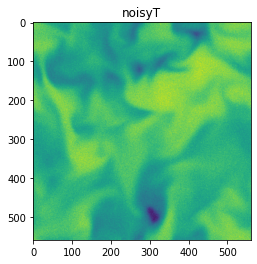

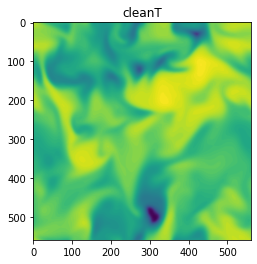

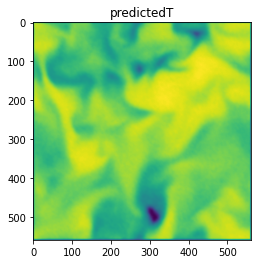

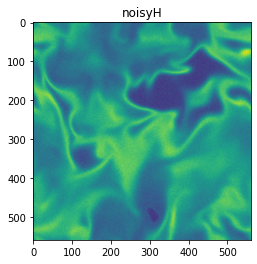

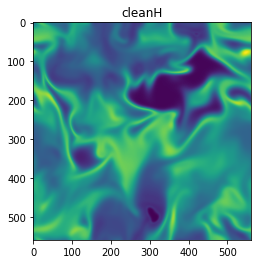

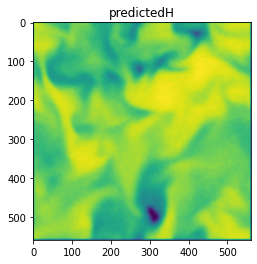

In [ ]:
# predict and visualize on training data
predicted = autoencoder.predict(train_df_noisy)[0]
for i in range(int(len(variablesIndex)/2)):
    img = predicted[i].reshape((560, 560))
    noisy_img = noisy_data[variablesName[i]]
    clean_img = clean_data[variablesName[i]]
    plt.title('noisy{}'.format(variablesName[i]))
    plt.imshow(noisy_img)
    plt.show()
    plt.title('clean{}'.format(variablesName[i]))
    plt.imshow(clean_img)
    plt.show()
    plt.title('predicted{}'.format(variablesName[i]))
    plt.imshow(img)
    plt.show()

In [ ]:
# predict and visualize on test data
predicted = autoencoder.predict(test_df_noisy)[0]
for i in range(int(len(variablesIndex)/2), int(len(variablesIndex))):
    img = predicted[i-int(len(variablesIndex)/2)].reshape((560, 560))
    noisy_img = noisy_data[variablesName[i]]
    clean_img = clean_data[variablesName[i]]
    plt.title('noisy{}'.format(variablesName[i]))
    plt.imshow(noisy_img)
    plt.show()
    plt.title('clean{}'.format(variablesName[i]))
    plt.imshow(clean_img)
    plt.show()
    plt.title('predicted{}'.format(variablesName[i]))
    plt.imshow(img)
    plt.show()